In [1]:
!pip install ipython-autotime
%matplotlib inline
%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-py3-none-any.whl size=1830 sha256=6130a6c5d8dcc063560e6c22b16b0f09f74edae00e80b39fed03ed5f56a7e03c
  Stored in directory: /root/.cache/pip/wheels/28/3a/38/7ecc013df8b58518cf859fb86c67c53df318426e96bb9fe1c0
Successfully built ipython-autotime


**Importing the required libraries**

In [2]:
import numpy as np 
import pandas as pd 
import os,re
import unicodedata
import matplotlib.pyplot as plt

import nltk

# from googletrans import Translator

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

time: 8.55 s


# Configuring and Enabling the TPU

In [3]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

time: 3.21 s


# *Writing the input data files to pandas dataframe*

In [4]:
data_path = '/kaggle/input/jigsaw-multilingual-toxic-comment-classification/'

# loading all the train datasets

# train_data1 = pd.read_csv(data_path + 'jigsaw-toxic-comment-train.csv')
train_data2 = pd.read_csv(data_path + 'jigsaw-toxic-comment-train-processed-seqlen128.csv')
# train_data3 = pd.read_csv(data_path + 'jigsaw-unintended-bias-train.csv')
# train_data4 = pd.read_csv(data_path + 'jigsaw-unintended-bias-train-processed-seqlen128.csv')

# loading all the validation and test datasets

# validation_data1 = pd.read_csv(data_path +  'validation.csv')
validation_data2 = pd.read_csv(data_path + 'validation-processed-seqlen128.csv')

# test_data1 = pd.read_csv(data_path +  'test.csv')
test_data2 = pd.read_csv(data_path + 'test-processed-seqlen128.csv')

# the submission file
sub = pd.read_csv(data_path + 'sample_submission.csv')

time: 6.23 s


# **Preparing train, validation and test data**

In [5]:
train_data2.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,input_word_ids,input_mask,all_segment_id
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,"(101, 27746, 31609, 11809, 24781, 10105, 70971...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,"(101, 141, 112, 56237, 10874, 106, 10357, 1825...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,"(101, 35936, 10817, 117, 146, 112, 181, 30181,...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,"(101, 107, 15946, 146, 10944, 112, 188, 13086,...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,"(101, 11065, 117, 52523, 117, 10301, 15127, 51...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


time: 30 ms


In [6]:
train_inputs_word_ids = np.array([np.array(eval(i)) for i in train_data2['input_word_ids']])
train_inputs_word_ids = pad_sequences(train_inputs_word_ids, maxlen=256, padding='post',truncating='post')

train_labels = np.array(train_data2.iloc[:,2:3])

print('Train data input shape = ', train_inputs_word_ids.shape)
print('Train labels shape = ', train_labels.shape)

Train data input shape =  (223549, 256)
Train labels shape =  (223549, 1)
time: 53.1 s


In [7]:
validation_data2.head()

,id,comment_text,lang,toxic,input_word_ids,input_mask,all_segment_id
0,0,Este usuario ni siquiera llega al rango de ...,es,0,"(101, 12515, 82849, 10414, 10294, 39190, 10113...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,Il testo di questa voce pare esser scopiazzato...,it,0,"(101, 10282, 29346, 10120, 14508, 19696, 22606...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1,"(101, 32286, 119, 101911, 11419, 27119, 10797,...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0,"(101, 11916, 10824, 71339, 10245, 15499, 24542...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0,"(101, 47197, 20267, 10371, 14349, 66513, 31268...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


time: 12.7 ms


In [8]:
valid_inputs_word_ids = np.array([np.array(eval(i)) for i in validation_data2['input_word_ids']])
valid_inputs_word_ids = pad_sequences(valid_inputs_word_ids, maxlen=256, padding='post',truncating='post')

valid_labels = np.array(validation_data2.iloc[:,3:4])

print('Valid data input shape = ', valid_inputs_word_ids.shape)
print('Valid labels shape = ', valid_labels.shape)

Valid data input shape =  (8000, 256)
Valid labels shape =  (8000, 1)
time: 1.98 s


In [9]:
test_data2.head()

,id,comment_text,input_word_ids,input_mask,all_segment_id
0,0,Doctor Who adlı viki başlığına 12. doctor olar...,"(101, 17376, 14516, 19165, 56324, 10116, 24542...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,"Вполне возможно, но я пока не вижу необходимо...","(101, 511, 53204, 36689, 44504, 117, 11279, 57...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,"Quindi tu sei uno di quelli conservativi , ...","(101, 35921, 17938, 13055, 13868, 11381, 10120...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,Malesef gerçekleştirilmedi ancak şöyle bir şey...,"(101, 59170, 16822, 99087, 10284, 83972, 51782...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...,"(101, 131, 32070, 11759, 131, 11045, 23388, 10...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


time: 11.6 ms


In [10]:
test_inputs_word_ids = np.array([np.array(eval(i)) for i in test_data2['input_word_ids']])
test_inputs_word_ids = pad_sequences(test_inputs_word_ids, maxlen=256, padding='post',truncating='post')

print('Valid data input shape = ', test_inputs_word_ids.shape)

Valid data input shape =  (63812, 256)
time: 15.8 s


# Preparing a basic Model

In [11]:
vocab_size = 500000
embedding_dim = 128
max_length = 256
num_epochs = 2

time: 827 µs


In [12]:
with tpu_strategy.scope():
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, trainable=True),
        
        tf.keras.layers.Conv1D(filters=64, kernel_size=5, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling1D(),
        
        tf.keras.layers.Conv1D(filters=64, kernel_size=5, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling1D(),
        
        tf.keras.layers.GlobalMaxPooling1D(),
#         tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),

#         tf.keras.layers.Flatten(),
#         tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    
    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 128)          64000000  
_________________________________________________________________
conv1d (Conv1D)              (None, 256, 64)           41024     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 128, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 64)           20544     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 64, 64)            0         
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0

In [13]:
history = model.fit(train_inputs_word_ids[:223520], train_labels[:223520], 
                    epochs=num_epochs, 
                    validation_data=(valid_inputs_word_ids, valid_labels)
         )

Train on 223520 samples, validate on 8000 samples
Epoch 1/2
223520/223520 [==============================] - 158s 709us/sample - loss: 0.1424 - accuracy: 0.9459 - val_loss: 0.4348 - val_accuracy: 0.8448
Epoch 2/2
223520/223520 [==============================] - 153s 685us/sample - loss: 0.1041 - accuracy: 0.9586 - val_loss: 0.5587 - val_accuracy: 0.8470
time: 5min 12s


*Plotting the accuracy and loss graphs*

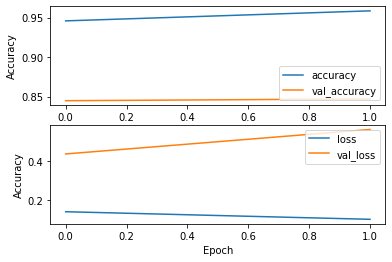

time: 373 ms


In [14]:
plt.subplot(2,1,1)    
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(2,1,2)    
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')

Making Prediction using the model on the test data

In [15]:
prediction=model.predict(test_inputs_word_ids)
prediction.shape

(63812, 1)

time: 1min


*Preparing the submission.csv file*

In [16]:
pred_id=test_data2['id']
data_tuples = list(zip(pred_id,prediction.reshape((63812,)).tolist()))
test_df=pd.DataFrame(data_tuples, columns=['id','toxic'])
test_df.to_csv("submission.csv",index=False)

time: 645 ms


In [17]:
test_df.head()

,id,toxic
0,0,0.007661
1,1,0.004417
2,2,0.002492
3,3,0.002687
4,4,0.051547


time: 16.5 ms
